In [2]:
import pandas as pd
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 50)

import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from datetime import datetime as dt
import glob
import os

In [3]:
# importing json files

dfs=[]
for file in glob.glob("data/*.json"):
    dataframe = pd.read_json(file)['posts']
    # flatten the structure
    dataframe = pd.json_normalize(dataframe)
    # insert file names
    dataframe['file_name'] = os.path.basename(file)
    dfs.append(dataframe)

# concatenate all data and drop repeated entries
df=pd.concat(dfs).drop_duplicates(subset='uuid', keep='last')

In [4]:
# slicing out only relevant columns 

selected_columns = [
    'file_name',
    'uuid', 
    'title',
    'content',
    'post_flair_text',
    'author',
    'author_flair_text',
    'created',
    'comments',
    'score_up',
    'preview',
    'link',
    'domain',
    'is_image',
    'is_video',
    'video_link'
    ]	
df = df[selected_columns]

# Replace empty cell with Nan
dataframe = dataframe.replace(r'^\s*$', np.nan, regex=True)

# Format datetime
df['created'] = pd.to_datetime(df.created, unit='ms').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
# crate a column storing "date" 
df['created_date'] = df['created'].dt.date
df['created_date'] = df['created_date'].astype(str)


# Fix empty or ill-formed domain column
selfpost_mask = df.domain.str.match('^$')
df.loc[selfpost_mask, 'domain'] = 'self_post'

df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 22253 entries, 2 to 24
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype                     
---  ------             --------------  -----                     
 0   file_name          22253 non-null  object                    
 1   uuid               22253 non-null  object                    
 2   title              22253 non-null  object                    
 3   content            22253 non-null  object                    
 4   post_flair_text    22253 non-null  object                    
 5   author             22253 non-null  object                    
 6   author_flair_text  22253 non-null  object                    
 7   created            22253 non-null  datetime64[ns, US/Eastern]
 8   comments           22253 non-null  int64                     
 9   score_up           22253 non-null  int64                     
 10  preview            22253 non-null  object                    
 11  link               2225

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_6845/3768255955.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe = dataframe.replace(r'^\s*$', np.nan, regex=True)


In [5]:
# Due to the lack of data, removing all posts from 2024-07-21

df = df[df['created_date'] != '2024-07-21']

df.value_counts('created_date').sort_index()

created_date
2024-07-22    576
2024-07-23    615
2024-07-24    599
2024-07-25    620
2024-07-26    586
2024-07-27    629
2024-07-28    623
2024-07-29    646
2024-07-30    581
2024-07-31    622
2024-08-01    582
2024-08-02    624
2024-08-03    636
2024-08-04    635
2024-08-05    647
2024-08-06    614
2024-08-07    584
2024-08-08    608
2024-08-09    604
2024-08-10    585
2024-08-11    622
2024-08-12    674
2024-08-13    605
2024-08-14    612
2024-08-15    618
2024-08-16    609
2024-08-17    616
2024-08-18    590
2024-08-19    653
2024-08-20    589
2024-08-21    607
2024-08-22    621
2024-08-23    618
2024-08-24    588
2024-08-25    591
2024-08-26    626
2024-08-27    136
Name: count, dtype: int64

In [6]:
# Keep only the top 500 posts by "score_up" from each date so that the playing field is more leveled
df = df.groupby('created_date').apply(lambda x: x.nlargest(500, 'score_up')).reset_index(drop=True)

df.value_counts("created_date").sort_index()

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_6845/3108082903.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('created_date').apply(lambda x: x.nlargest(500, 'score_up')).reset_index(drop=True)


created_date
2024-07-22    500
2024-07-23    500
2024-07-24    500
2024-07-25    500
2024-07-26    500
2024-07-27    500
2024-07-28    500
2024-07-29    500
2024-07-30    500
2024-07-31    500
2024-08-01    500
2024-08-02    500
2024-08-03    500
2024-08-04    500
2024-08-05    500
2024-08-06    500
2024-08-07    500
2024-08-08    500
2024-08-09    500
2024-08-10    500
2024-08-11    500
2024-08-12    500
2024-08-13    500
2024-08-14    500
2024-08-15    500
2024-08-16    500
2024-08-17    500
2024-08-18    500
2024-08-19    500
2024-08-20    500
2024-08-21    500
2024-08-22    500
2024-08-23    500
2024-08-24    500
2024-08-25    500
2024-08-26    500
2024-08-27    136
Name: count, dtype: int64

In [7]:
# Extract twitter handles 
df[df.domain =='twitter.com'].link.str.split('/').str[3].str.lower()
df.loc[df.domain == 'twitter.com', 'twitter_handle'] = df[df.domain == 'twitter.com'].link.str.split('/').str[3].str.lower()
df['twitter_handle'].fillna(np.nan, inplace=True)

# Top twitter handles mentioned
df.value_counts('twitter_handle', ascending=False).head(10)

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_6845/3006735851.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['twitter_handle'].fillna(np.nan, inplace=True)


twitter_handle
elonmusk        256
behizytweets    247
endwokeness     156
libsoftiktok    131
catturd2        105
dc_draino       102
immeme0         102
bennyjohnson     99
trumpwarroom     85
nicksortor       85
Name: count, dtype: int64

In [79]:
import spacy
import nltk
nltk.download('wordnet')
from nltk import bigrams, trigrams
nlp = spacy.load('en_core_web_lg')
stopwords = list(nlp.Defaults.stop_words) 


import contractions
import emoji
import re



def clean_it_all_up (text, extra_stops):
    text = emoji.replace_emoji(text)
    text = contractions.fix(text)
    text = re.sub(r'\W+', ' ', text)
    doc = nlp(text)
    lemmatized_tokens = []
    
    for token in doc:
        if (
            token.text.lower() not in stopwords 
            and (extra_stops is None or token.text.lower() not in extra_stops) 
            # and token.pos_ in {'NOUN', 'PROPN', 'VERB', 'ADJ'} 
            # and token.ent_type_ not in {'GPE', 'LOC'}
            and token.pos_ not in {"AUX",
                                   "ADP",
                                   "CONJ", 
                                   "CCONJ", 
                                   "DET", 
                                   "INTJ", 
                                   "PART", 
                                   "PUNCT",
                                   "SCONJ", 
                                   "SYM", 
                                   "X", 
                                   "SPACE"}
        ):
          
            
            lemmatized_tokens.append(token.lemma_.lower())
            
    return " ".join(lemmatized_tokens)   


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/keenansmacbookairm3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
text = "Donald Trump loves pancakes. So do I."
extra_stops=['trump']

clean_it_all_up(text, extra_stops)

'donald love pancake'

In [12]:
def date_selection(start_date, end_date):
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")

    date_list = []
    current_date = start_date
    date_list.append(current_date.strftime('%Y-%m-%d'))

    while current_date < end_date:
        next_date = current_date + datetime.timedelta(days=1)
        next_date = next_date
        if next_date >= end_date:
            next_date = end_date
        date_list.append(next_date.strftime('%Y-%m-%d'))
        current_date = next_date

    return date_list


In [13]:
def ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n=None):
    
    date_list = date_selection(start_date, end_date)

    cleaned_tokens = ' '.join(dataframe[dataframe.created_date.isin(date_list)]['title'].apply(lambda x: clean_it_all_up(x, extra_stops)).tolist())

    if num == 1:
        ngram = pd.Series(cleaned_tokens.split()).value_counts()
    elif num == 2:
        ngram = pd.Series(list(bigrams(cleaned_tokens.split()))).value_counts()
    elif num == 3:
        ngram = pd.Series(list(trigrams(cleaned_tokens.split()))).value_counts()
    else:
        raise ValueError('Invalid number. Must choose between 1, 2, or 3.')
    
    ngram = ngram[ngram > 1].head(top_n)
    return ngram


In [15]:
ngram_generator(dataframe = df, num=2, start_date='2024-07-22', end_date='2024-08-22', extra_stops=['trump'], top_n=None)

(kamala, harris)     846
(tim, walz)          314
(secret, service)    268
(joe, biden)         190
(elon, musk)         171
                    ... 
(election, hack)       2
(child, gender)        2
(overlay, device)      2
(final, stage)         2
(carano, move)         2
Name: count, Length: 15668, dtype: int64

In [37]:
"ago" in stopwords

False

In [29]:
def ngram_generator_24hrs(dataframe, num, extra_stops, top_n=None):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=1)
    
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")
    
    return ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n)

In [69]:
ngram_generator_24hrs(dataframe = df, num=2, extra_stops=['trump'], top_n=20)

(rfk, jr)                    27
(kamala, harris)             25
(biden, harris)              22
(tulsi, gabbard)             13
(mark, zuckerberg)           10
(million, ineligible)         8
(1, million)                  8
(kennedy, jr)                 7
(joe, biden)                  7
(ineligible, voter)           7
(f, kennedy)                  7
(illegal, alien)              7
(robert, f)                   7
(zuckerberg, admit)           7
(tim, walz)                   6
(facebook, censor)            6
(censor, americans)           6
(voter, roll)                 6
(non, citizen)                6
(afghanistan, withdrawal)     6
Name: count, dtype: int64

In [71]:
# A function to return a wordcloud chart covering a specific period of dates
from wordcloud import WordCloud

def ngram_cloud(dataframe, num, start_date, end_date, extra_stops, top_n=None):
    ngram = ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n)
    words_cloud = pd.DataFrame(ngram, columns=['count']).reset_index().rename(columns={'index': 'phrases'})
    words_cloud['phrases'] = words_cloud['phrases'].apply(lambda x: ', '.join(x) if isinstance(x,tuple) else x)
    words_cloud['phrases'] = words_cloud['phrases'].str.replace(',', '')
    wordcloud = WordCloud(width=800, height=400, background_color='white').\
    generate_from_frequencies(words_cloud.set_index('phrases')['count'].to_dict())
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

In [72]:
# A function to return a wordcloud chart covering ONLY the past 24 hours

def ngram_24hrs_cloud(dataframe, num, save_viz, extra_stops, top_n=None):
    ngram = ngram_generator_24hrs(dataframe, num, extra_stops, top_n)
    words_cloud = pd.DataFrame(ngram, columns=['count']).reset_index().rename(columns={'index': 'phrases'})
    words_cloud['phrases'] = words_cloud['phrases'].apply(lambda x: ', '.join(x) if isinstance(x,tuple) else x)
    words_cloud['phrases'] = words_cloud['phrases'].str.replace(',', '')
    wordcloud = WordCloud(width=800, height=400, background_color='white').\
    generate_from_frequencies(words_cloud.set_index('phrases')['count'].to_dict())
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, 
               interpolation='nearest',
               aspect="auto"
               )
    plt.title(f"Top {top_n} bigrams in the last 24 hours",
              fontsize=20,
              pad=25,
              )
    plt.axis('off')

    if save_viz is not None:
        plt.savefig(f"viz/{save_viz}.jpeg",
                    dpi=600
                    )
        plt.show()
    else:
        plt.show()

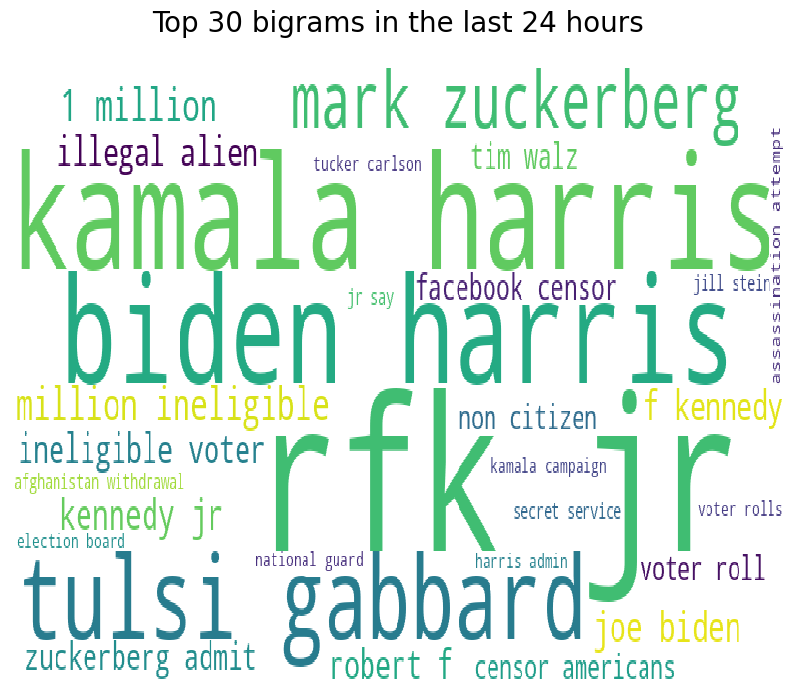

In [73]:
# creating and saving the top 50 bigrams from the last 24 hours
dataframe = df
num = 2
top_n = 30
save_viz = None
extra_stops=['trump']
ngram_24hrs_cloud(dataframe = dataframe, num=num, top_n=top_n, save_viz=save_viz, extra_stops=extra_stops)


In [81]:
# A function of returning top ngrams from the past 7 days

def ngram_generator_7days(dataframe, num, extra_stops, top_n=None):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=7)
    
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")
    
    return ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n)

In [82]:
dataframe = df
num = 2
top_n = 50
save_viz = None
extra_stops=['trump']

ngram_generator_7days(dataframe = dataframe, num=num, extra_stops=extra_stops,  top_n=top_n)

(rfk, jr)                   180
(kamala, harris)            109
(tim, walz)                  58
(biden, harris)              43
(elon, musk)                 42
(secret, service)            38
(joe, biden)                 32
(kennedy, jr)                25
(supreme, court)             24
(f, kennedy)                 24
(robert, f)                  24
(year, old)                  24
(free, speech)               23
(jd, vance)                  21
(assassination, attempt)     20
(illegal, alien)             20
(dnc, convention)            18
(tulsi, gabbard)             18
(2024, election)             16
(1, million)                 16
(white, house)               16
(year, ago)                  16
(united, states)             15
(fake, news)                 15
(fox, news)                  15
(nicole, shanahan)           15
(democratic, party)          15
(attorney, general)          14
(harris, campaign)           14
(pavel, durov)               14
(foo, fighters)              14
(dnc, sp

In [83]:
# A function to return a wordcloud chart covering ONLY the past 7 days


def ngram_7days_cloud(dataframe, num, save_viz, extra_stops, top_n=None):
    ngram = ngram_generator_7days(dataframe, num, extra_stops, top_n=None)
    words_cloud = pd.DataFrame(ngram, columns=['count']).reset_index().rename(columns={'index': 'phrases'})
    words_cloud['phrases'] = words_cloud['phrases'].apply(lambda x: ', '.join(x) if isinstance(x,tuple) else x)
    words_cloud['phrases'] = words_cloud['phrases'].str.replace(',', '')
    wordcloud = WordCloud(width=800, height=400, background_color='white').\
    generate_from_frequencies(words_cloud.set_index('phrases')['count'].to_dict())
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Top {top_n} bigrams in the last 7 days",
              fontsize=20,
              pad=25,
              )

    if save_viz is not None:
        plt.savefig(f"viz/{save_viz}.jpeg",
                    dpi=600
                    )
        plt.show()
    else:
        plt.show()

In [1]:
# creating and saving the top 50 bigrams from the last 24 hours
dataframe = df
num = 2
top_n = 50
save_viz = None
extra_stops=None
ngram_7days_cloud(dataframe = dataframe, num=num, top_n=top_n, save_viz=save_viz, extra_stops=['trump'])


NameError: name 'df' is not defined